# Integration of genetic determinants and GSM: FVA 

In [29]:
import cobra
import re
import json
import sys
import os
from cobra import Reaction
from cameo import models
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx
from networkx.algorithms.community import greedy_modularity_communities

### Load genetic determinants

In [30]:
df_AB_all = pd.read_pickle('GSMGeneticDeterminants_bothdir.pkl')
genes_ALL = list(df_AB_all.index)

### Load model from bigg database using CAMEO

In [32]:
m = models.bigg.iML1515

# gene dictionaries for mapping between ID and names
gene_name_dic = {}
for g in m.genes:
    gene_name_dic[g.name] = g.id
    
gene_name_dic2 = {}
for g in m.genes:
    gene_name_dic2[g.id] = g.name

## FVA - glucose media

In [ ]:
## FVA on glucose only

m = models.bigg.iML1515
m.reactions.EX_glc__D_e.bounds = (-10.0, 1000.0)
m.reactions.EX_o2_e.bounds = (-18.5, 1000.0)


        
for reaction in m.reactions:
    if reaction.bounds != (0.0, 0.0):
        if reaction.reversibility:
            reaction.bounds = (-1, 1)
        else:
            reaction.bounds = (0, 1)

fva_res = {}

# compute for WT first
res = cobra.flux_analysis.flux_variability_analysis(m, fraction_of_optimum = 0.0, processes = 12)
fva_res['WT'] = res.to_dict()

for ind, gene in enumerate(genes_ALL):

    with m:
        m.genes.get_by_id(gene).knock_out()
        res = cobra.flux_analysis.flux_variability_analysis(m, fraction_of_optimum = 0.0, processes = 12)
    fva_res[gene] = res.to_dict()
    
    #with open('fva_res_m9.json', 'w') as fn:
    #    json.dump(fva_res, fn)
    
    
    

### Or load in previously saved results

In [33]:

import json
with open('fva_res_m9_2.json', 'r') as fn:
    FVA_res_ALL = json.load(fn)

In [34]:
reactions = []
for r in m.reactions:
    reactions.append(r.id)
FVA_res = pd.DataFrame(index = reactions)

count = 0
for strain, res in FVA_res_ALL.items():
    results = pd.DataFrame.from_dict(res)
    flux_span = pd.DataFrame(results.subtract([0,results['minimum']])['maximum'])
    if strain != 'WT':
        FVA_res.insert(count, column = strain, value = flux_span.values)
    else:
        FVA_res.insert(count, column = strain, value = flux_span.values)
        count += 1

In [35]:
IF_genes289 = pd.DataFrame(index = reactions)

IF_genes289.insert(0, column = 'WT', value = FVA_res['WT'])
count = 1
for col in FVA_res.columns:
    if col in genes_ALL:
        IF_genes289.insert(count, column = col, value = FVA_res[col])
        count += 1

# 2. Network analysis of the results

In [78]:
edges = []
for gene in IF_genes289.columns:
    if gene != 's0001':
        for ind, i in enumerate(IF_genes289[gene]):
            if IF_genes289['WT'][ind] > IF_genes289[gene][ind]:
                 if IF_genes289['WT'][ind] > 0.01:
                    if IF_genes289[gene][ind]/IF_genes289['WT'][ind] < 0.9:
                        edges.append((m.genes.get_by_id(gene).name, IF_genes289['WT'].index[ind]))


# turn into graph
nodes1 = []
nodes2 = []
for edge in edges:
    nodes1.append(edge[0])
    nodes2.append(edge[1])         
nodes1 = list(set(nodes1))
nodes2 = list(set(nodes2))

G = nx.Graph()
G.add_nodes_from(nodes1+nodes2)
G.add_edges_from(edges)
# get the degree
d = nx.degree(G)

In [37]:
print('Number of gene nodes:', len(nodes1))
print('Number of metabolite nodes:', len(nodes2))

Number of gene nodes: 145
Number of metabolite nodes: 861


### Run the greedy algorithm for clustering in networkx

In [38]:
c = list(greedy_modularity_communities(G))

In [39]:
# add labels to the nodes
gene_name_dic3 = {}
for g in m.genes:
    gene_name_dic3[g.name] = g.name
nx.set_node_attributes(G, gene_name_dic3, name = 'labels')


# colour code each metabolite in the network according to the cluster they have been assigned to
for met in nodes2:
    for ind, cluster in enumerate(c):
        if met in c[ind]:
            G.add_node(met, color = str(ind))

for gene in nodes1:
    for ind, cluster in enumerate(c):
        if gene in c[ind]:
            G.add_node(gene, color = str(ind))
                

                
# Save the network
#nx.write_gml(G, 'Bipartite_FVA_newGreedy_bothdir.gml')

# 3. Enrichment of metabolic pathways in the network clusters

In [36]:
# Get dataframe of all the reactions in the model relating to subsystems

In [40]:
subsystems = []
for i in m.reactions:
    subsystems.append(i.subsystem)
subsystems = list(set(subsystems))


reacs = []
for r in m.reactions:
    reacs.append(r.id)
df_reacs_sss_all = pd.DataFrame(index = reacs)

count = 0
for s in subsystems:
 
    s_genes = []
    for r in m.reactions:
        r_s = 0        
        if r.subsystem in s:

            r_s = 1
        s_genes.append(r_s)
    
    df_reacs_sss_all.insert(count, column = s, value = s_genes)
    count += 1

In [39]:
### Get the number of reactions in each subsystem for each cluster

In [41]:
df_reacs_c = pd.DataFrame(index = reacs)
for ind, i in enumerate(c):
    col = []
    count = 0
    for node in reacs:
        if node in c[ind]:
            col.append(1)
        else:
            col.append(0)
    df_reacs_c.insert(count, column = ind, value = col)
    count += 1
            
        
df_c_sss = df_reacs_c.T.dot(df_reacs_sss_all).T

In [42]:
from scipy import stats
sig_pathways_clusters40 = {}

for ind, cluster_id in enumerate(c):
    genes = []
    genes_pathway = {}
    if len(c[ind]) > 10.0:
        
        print('')
        print(ind)
        nodes_list = []
        for i in c[ind]:
            if i in nodes2:
                nodes_list.append(i)


        

            if i in nodes1:
                genes.append(i)

        p_value = []
        p_val_name = []
        for s in subsystems:
            
            x = df_c_sss[ind][s]
            M = df_reacs_sss_all.sum(axis = 0)[s]
            df_c_sss[ind]
            #print(ind, s, x, M)
            if M != 0.0 and x != 0.0:
                p = stats.hypergeom.sf(x, len(m.reactions), M, len(nodes_list))
            else:
                p = 1.0
                
                
            genes_path = []
            for ind_reac, reac in enumerate(df_reacs_sss_all[s]):
                if reac > 0:
                    if df_reacs_sss_all.index[ind_reac] in c[ind]:
                        reaction = df_reacs_sss_all.index[ind_reac]
                        genes = G.neighbors(reaction)
                        for ge in genes:
                            if ge in c[ind]:
                                genes_path.append(ge)
            genes_pathway[s] = list(set(genes_path))

                
                
            


            #if p < 0.05:
            #    print(ind, s, x, M, p)
                #if p < 0.05:
                #    print(ss, p)

            p_value.append(p)
            p_val_name.append(s)
        print('')       
        print('corrected significance:')       

        
        
        sig_pathways_clusters40[ind] = {}
        from operator import itemgetter
        indices, pval_sorted = zip(*sorted(enumerate(p_value), key=itemgetter(1)))
        sig_pathways = []
        for indj, i in enumerate(pval_sorted):
            if i < ((indj+1)/40)*0.01:
                sig_pathways.append(p_val_name[indices[indj]])
                sig_pathways_clusters40[ind].update({p_val_name[indices[indj]] : genes_pathway[p_val_name[indices[indj]]]})
                print(p_val_name[indices[indj]], i, ((indj+1)/40)*0.01)
                #print(p_val_name[indices[indj]])
                #print(((indj+1)/40)*0.01)
                #print(genes_pathway[p_val_name[indices[indj]]])
        if sig_pathways == []:
                sig_pathways_clusters40[ind] = {}




0

corrected significance:
Cell Envelope Biosynthesis 1.2655331520492277e-50 0.00025
Membrane Lipid Metabolism 1.2831802185914931e-42 0.0005
Lipopolysaccharide Biosynthesis / Recycling 1.18292733240415e-28 0.00075
Glycerophospholipid Metabolism 5.252575836676669e-12 0.001

1

corrected significance:
Valine, Leucine, and Isoleucine Metabolism 7.763115910704465e-19 0.00025
Threonine and Lysine Metabolism 9.999080099492162e-18 0.0005
Glycine and Serine Metabolism 9.477716186552276e-15 0.00075
Methionine Metabolism 9.477716186552276e-15 0.001
Cysteine Metabolism 2.6070708388298304e-12 0.00125
Folate Metabolism 4.620956607131675e-05 0.0015

2

corrected significance:
Nucleotide Salvage Pathway 7.146056936948876e-51 0.00025
Histidine Metabolism 4.733161272394508e-16 0.0005
Pentose Phosphate Pathway 1.6899353522496533e-05 0.00075
Methionine Metabolism 0.0002089873468759846 0.001

3

corrected significance:
Tyrosine, Tryptophan, and Phenylalanine Metabolism 3.660867404304418e-28 0.00025
Argin

### Significance of pathways from finer grained pathways (Biocyc database)

In [43]:

# get pathways to reaction relationship from BioCyc SMART tables
reac_pathways = pd.read_excel('Reaction_pathways.xlsx', sheet_name='Sheet1')
reac_pathways2 = pd.read_excel('Reaction_pathways2.xlsx', sheet_name='Sheet1')

# Use gene-reaction-pathway relationship from gene-pathway SMART table in Biocyc due to lack of biocyc reaction IDs in Bigg model
gene_pathways = pd.read_excel('Gene_pathways2.xlsx', sheet_name='Sheet1')




In [44]:
reac_pathways = pd.read_excel('Reaction_pathways.xlsx', sheet_name='Sheet1')
reac_pathways2 = pd.read_excel('Reaction_pathways2.xlsx', sheet_name='Sheet1')



In [45]:
reaction_pathways = {}
for i in m.reactions:
    pathways = []
    if 'biocyc' in i.annotation:
        for ind, reac in enumerate(reac_pathways['Reaction']):
            if i.annotation['biocyc'][0].split('META:')[1] == reac:
                #print(i, met_pathways2['Pathways of compound'][ind])
                if str(reac_pathways2['Pathways of a reaction'][ind]) != 'nan':
                    pathways = reac_pathways2['Pathways of a reaction'][ind].split(' // ')
    reaction_pathways[i.id] = pathways

In [46]:
pathways = []
for i, j in reaction_pathways.items():
    for path in j:
        pathways.append(path)
        
pathways = list(set(pathways))
len(pathways)

247

In [48]:

for i in m.genes:
    if i.id != 's0001':
        for ind, gene in enumerate(gene_pathways['column 1']):
            if gene_name_dic2[i.id] in gene:
                if str(gene_pathways['Pathways of gene'][ind]) != 'nan':
                    for r in m.genes.get_by_id(i.id).reactions:
                        if reaction_pathways[r.id] == []:
                            reaction_pathways[r.id] = gene_pathways['Pathways of gene'][ind].split(' // ')

In [49]:
for i, j in reaction_pathways.items():
    for path in j:
        pathways.append(path)
        
pathways = list(set(pathways))
len(pathways)


396

### Significance test using hypergeometric 

In [50]:
# get significance

sig_pathways_clusters = {}
for ind, cluster in enumerate(c):
    if len(c[ind]) > 10.0:
        print(ind)
        p_value = []
        p_val_name = []
        genes_pathway = {}
        for i in pathways:
            number_reacs_ml = 0.0
            number_reacs_model = 0.0
            genes_path = []
            for reac, j in reaction_pathways.items():
                for path in j:
                    if i == path:
                        if reac in c[ind]:
                            number_reacs_ml += 1.0
                            for ge in nodes1:
                                if (ge, reac) in edges:
                                    if ge in c[ind]:
                                        genes_path.append(ge)

                        if reac in m.reactions:
                            number_reacs_model += 1.0


            l_c = 0.0
            for reac in c[ind]:
                if reac in nodes2:
                    l_c += 1.0
            if number_reacs_ml > 3.0:
                p = stats.hypergeom.sf(number_reacs_ml, len(m.reactions), number_reacs_model, l_c)
                #if p < 0.05:
                    #print(i, p, number_reacs_ml, number_reacs_model)

                p_value.append(p)
                p_val_name.append(i)
                genes_pathway[i] = list(set(genes_path))

            else:
                p_value.append(1.0)
                p_val_name.append(i)


        print('')       
        print('corrected significance:')       

        sig_pathways_clusters[ind] = {}
        from operator import itemgetter
        indices, pval_sorted = zip(*sorted(enumerate(p_value), key=itemgetter(1)))
        for indj, i in enumerate(pval_sorted):
            if i < ((indj+1)/396)*0.01:
                print(p_val_name[indices[indj]], i, ((indj+1)/396)*0.01)
                #print(((indj+1)/396)*0.01)
                sig_pathways_clusters[ind].update({p_val_name[indices[indj]] : genes_pathway[p_val_name[indices[indj]]]})
                #print(genes_pathway[p_val_name[indices[indj]]])



0

corrected significance:
lipid A-core biosynthesis (<i>E. coli</i> K-12) 0.0 2.5252525252525256e-05
CMP-3-deoxy-D-<I>manno</I>-octulosonate biosynthesis 0.0 5.050505050505051e-05
dTDP-<i>N</i>-acetylthomosamine biosynthesis 0.0 7.575757575757576e-05
ADP-L-<i>glycero</i>-&beta;-D-<i>manno</i>-heptose biosynthesis 0.0 0.00010101010101010102
dTDP-&beta;-L-rhamnose biosynthesis 0.0 0.00012626262626262626
superpathway of unsaturated fatty acids biosynthesis (<i>E. coli</i>) 1.5601066169811855e-81 0.00015151515151515152
superpathway of fatty acid biosynthesis I (E. coli) 3.237780809707816e-57 0.00017676767676767677
<i>cis</i>-vaccenate biosynthesis 1.851741434384002e-52 0.00020202020202020205
palmitoleate biosynthesis I (from (5Z)-dodec-5-enoate) 8.674715769444265e-47 0.00022727272727272727
fatty acid elongation -- saturated 9.235388982604098e-45 0.0002525252525252525
biotin biosynthesis I 5.500030088629609e-43 0.0002777777777777778
palmitate biosynthesis (type II fatty acid synthase) 8.67

### Group some of the pathways for visualisation of most significant metabolic processes in cytoscape

In [51]:
# Merge the groups

#Readily available and abundant host unsaturated fatty acids, such as oleate, can circumvent inactivating mutations in these pathways, making unsaturated fatty acid synthesis a target that is unlikely to receive much attention in the drug discovery field.


    
# group some of the pathways

grouped_sig_pathways = {}
grouped_sig_pathways['Proline metabolism'] = ['L-proline biosynthesis I (from L-glutamate)', 'Arginine and Proline Metabolism']
grouped_sig_pathways['Fatty acid degradation'] = ['fatty acid &beta;-oxidation I (generic)',
                                                 'oleate &beta;-oxidation']
grouped_sig_pathways['Purine metabolism'] = ['superpathway of purine nucleotides <i>de novo</i> biosynthesis II',
                                              'guanosine ribonucleotides <i>de novo</i> biosynthesis',
                                              'superpathway of guanosine nucleotides <i>de novo</i> biosynthesis II',
                                              'superpathway of histidine, purine, and pyrimidine biosynthesis',
                                              'superpathway of guanine and guanosine salvage', 
                                               'adenine and adenosine salvage III', 
                                               'guanine and guanosine salvage III',
                                               'guanine and guanosine salvage',
                                               'xanthine and xanthosine salvage',
                                               'adenine and adenosine salvage II',
                                               'adenine and adenosine salvage V',
                                               'guanosine deoxyribonucleotides <i>de novo</i> biosynthesis II',
                                               "inosine-5'-phosphate biosynthesis I",
                                               "purine ribonucleosides degradation",
                                             "adenosine nucleotides degradation II",
                                             "guanosine nucleotides degradation III"
                                             "purine deoxyribonucleosides degradation I",
                                             "superpathway of purine deoxyribonucleosides degradation",
                                             "superpathway of purine nucleotides <i>de novo</i> biosynthesis II",
                                             "adenosine ribonucleotides <i>de novo</i> biosynthesis",
                                             "purine deoxyribonucleosides degradation I",
                                             "guanosine nucleotides degradation III",
                                             "superpathway of adenosine nucleotides <i>de novo</i> biosynthesis II",
                                             "5-aminoimidazole ribonucleotide biosynthesis I",
                                             '5-aminoimidazole ribonucleotide biosynthesis II',
                                             'superpathway of 5-aminoimidazole ribonucleotide biosynthesis',
                                             "Nucleotide Salvage Pathway", 
                                             'adenosine deoxyribonucleotides <i>de novo</i> biosynthesis II'
                                             
                                              ]


grouped_sig_pathways['Folate metabolism'] = ['superpathway of tetrahydrofolate biosynthesis', 
                                            '6-hydroxymethyl-dihydropterin diphosphate biosynthesis I',
                                            'folate transformations III (<i>E. coli</i>)',
                                            'tetrahydrofolate biosynthesis', 'folate polyglutamylation', 'Folate Metabolism']



grouped_sig_pathways['Energy carriers biosynthesis'] = ['NAD salvage pathway I', 
                                                        'flavin biosynthesis I (bacteria and plants)',
                                                       'NAD salvage pathway IV (from nicotinamide riboside)',
                                                       'NAD salvage pathway I (PNC VI cycle)',
                                                       '2-carboxy-1,4-naphthoquinol biosynthesis', 
                                                       'superpathway of ubiquinol-8 biosynthesis (early decarboxylation)',
                                                       'superpathway of menaquinol-8 biosynthesis I',
                                                       'glutathione-glutaredoxin redox reactions',
                                                       'ubiquinol-8 biosynthesis (early decarboxylation)']

grouped_sig_pathways['Nucleic acid processing'] = ['tRNA processing', 'tRNA-uridine 2-thiolation and selenation (bacteria)',
                                                  'queuosine biosynthesis I (<i>de novo</i>)']


grouped_sig_pathways['Peptidoglycan metabolism'] = ['muropeptide degradation', 
                                                    'peptidoglycan biosynthesis I (<I>meso</I>-diaminopimelate containing)',
                                                    'UDP-<i>N</i>-acetylmuramoyl-pentapeptide biosynthesis I (<i>meso</i>-diaminopimelate containing)',
                                                    'anhydromuropeptides recycling I', 'peptidoglycan maturation (<i>meso</i>-diaminopimelate containing)', 'Murein Biosynthesis',
                                                    'Murein Recycling',
                                                    
                                                   ]

grouped_sig_pathways['Fatty acid and lipid biosynthesis'] = ['fatty acid biosynthesis initiation III', '(5Z)-dodecenoate biosynthesis I',
                                                            'fatty acid biosynthesis initiation (type II)', 'superpathway of unsaturated fatty acids biosynthesis (<i>E. coli</i>)',
                                                            'superpathway of fatty acid biosynthesis initiation (E. coli)', '(Kdo)<sub>2</sub>-lipid A biosynthesis I (E. coli)',
                                                             'fatty acid elongation -- saturated', 'palmitoleate biosynthesis I (from (5Z)-dodec-5-enoate)', 'fatty acid biosynthesis initiation II',
                                                            'superpathway of fatty acid biosynthesis I (E. coli)', '<i>cis</i>-vaccenate biosynthesis', 'palmitate biosynthesis (type II fatty acid synthase)', 'Membrane Lipid Metabolism']

grouped_sig_pathways['Pyrimidine metabolism'] = ['salvage pathways of pyrimidine deoxyribonucleotides', 
                                                'superpathway of pyrimidine ribonucleosides salvage',
                                                'superpathway of pyrimidine deoxyribonucleotides <i>de novo</i> biosynthesis',
                                                'salvage pathways of pyrimidine ribonucleotides',
                                                 'pyrimidine deoxyribonucleosides degradation',
                                                 'pyrimidine deoxyribonucleotide phosphorylation',
                                                 'pyrimidine deoxyribonucleotides <i>de novo</i> biosynthesis I',
                                                 'superpathway of pyrimidine deoxyribonucleosides degradation',
                                                 'pyrimidine ribonucleosides salvage I',
                                                 'superpathway of pyrimidine deoxyribonucleotides <i>de novo</i> biosynthesis (<i>E. coli</i>)',
                                                 'pyrimidine deoxyribonucleotides dephosphorylation',
                                                 'pyrimidine deoxyribonucleotides <i>de novo</i> biosynthesis II',
                                                 'pyrimidine nucleobases salvage I',
                                                 'pyrimidine ribonucleosides salvage III',
                                                 'pyrimidine ribonucleosides salvage II',
                                                 'pyrimidine nucleobases salvage II',
                                                 'CMP phosphorylation', 
                                                 'superpathway of pyrimidine ribonucleotides <i>de novo</i> biosynthesis',
                                                 'pyrimidine ribonucleosides degradation',
                                                 'superpathway of pyrimidine nucleobases salvage',
                                                 'UMP biosynthesis I',
                                                 'uracil degradation III'
                                                                                                 ]

grouped_sig_pathways['Lipolysaccharides metabolism'] = ['superpathway of lipopolysaccharide biosynthesis',
                                                        'lipid A-core biosynthesis (<i>E. coli</i> K-12)',
                                                        'superpathway of (Kdo)<SUB>2</SUB>-lipid A biosynthesis',
                                                        'Kdo transfer to lipid IV<sub>A</sub> I (E. coli)',
                                                        'lipid IV<sub>A</sub> biosynthesis (E. coli)',
                                                        'polymyxin resistance', 'Lipopolysaccharide Biosynthesis / Recycling',
                                                       ]

grouped_sig_pathways['Enterobactin metabolism'] = ['enterobacterial common antigen biosynthesis', 
                                                   'enterobactin biosynthesis']

grouped_sig_pathways['Carrier biosynthesis'] = ['acyl carrier protein metabolism']


grouped_sig_pathways['Heme metabolism'] = ['heme <i>b</i> biosynthesis II (oxygen-independent)', 
                                          'heme <i>b</i> biosynthesis V (aerobic)',
                                          'superpathway of heme <i>b</i> biosynthesis from uroporphyrinogen-III',
                                           'cytochrome <i>c</i> biogenesis (system I type)'
                                          ]
grouped_sig_pathways['Chorismate metabolism'] = ['superpathway of chorismate metabolism', 'chorismate biosynthesis from 3-dehydroquinate']

grouped_sig_pathways['Electron transport chain'] = ['hydrogen to fumarate electron transfer', 'NADH to fumarate electron transfer', 'NADH to hydrogen peroxide electron transfer']
grouped_sig_pathways['Phospholipid metabolism'] = ['superpathway of phospholipid biosynthesis I (bacteria)', 'CDP-diacylglycerol biosynthesis I', 'cardiolipin biosynthesis III', 'CDP-diacylglycerol biosynthesis II', 'Glycerophospholipid Metabolism',
                                                  'phosphatidylserine and phosphatidylethanolamine biosynthesis I',]
grouped_sig_pathways["Pyridoxal 5'-phosphate biosynthesis"] = ["superpathway of pyridoxal 5'-phosphate biosynthesis and salvage",
                                                              "pyridoxal 5'-phosphate salvage I"]

grouped_sig_pathways['Sugar nucleotide biosynthesis'] = ['UDP-&alpha;-D-galactose biosynthesis', 
                                                        'UDP-<i>N</i>-acetyl-&alpha;-D-mannosaminouronate biosynthesis',
                                                        'galactose degradation I (Leloir pathway)',
                                                        'dTDP-&beta;-L-rhamnose biosynthesis',
                                                        'UDP-&alpha;-D-glucuronate biosynthesis (from UDP-glucose)',
                                                         'dTDP-<i>N</i>-acetylthomosamine biosynthesis',
                                                        '<i>O</i>-antigen building blocks biosynthesis (<i>E. coli</i>)',
                                                        'ADP-L-<i>glycero</i>-&beta;-D-<i>manno</i>-heptose biosynthesis',
                                                         'CMP-3-deoxy-D-<I>manno</I>-octulosonate biosynthesis']
grouped_sig_pathways['Allantoin degradation'] = ['allantoin degradation IV (anaerobic)', 'allantoin degradation to glyoxylate III']
grouped_sig_pathways['putrescine degradation'] = ['putrescine degradation II']

grouped_sig_pathways['Sulfur compound metabolism'] = ['assimilatory sulfate reduction I', 'superpathway of sulfate assimilation and cysteine biosynthesis']

grouped_sig_pathways['Tetrapyrrole biosynthesis'] = ['tetrapyrrole biosynthesis I (from glutamate)']
grouped_sig_pathways['Biotin metabolism'] = ['biotin biosynthesis I', 'biotin biosynthesis from 8-amino-7-oxononanoate I']
grouped_sig_pathways['Autoinducer AI-2 biosynthesis'] = ['autoinducer AI-2 biosynthesis I']


grouped_sig_pathways['Tyrosine, Tryptophan, and Phenylalanine Metabolism'] = ['Tyrosine, Tryptophan, and Phenylalanine Metabolism', 'L-tyrosine biosynthesis I', 'L-tryptophan biosynthesis',]
grouped_sig_pathways['Cysteine metabolism'] = ['L-cysteine biosynthesis VII (from <i>S</i>-sulfo-L-cysteine)', 'Cysteine Metabolism', 'L-cysteine degradation II']
grouped_sig_pathways['Histidine metabolism'] = ['Histidine metabolism', 'L-histidine biosynthesis', 'Histidine Metabolism']

grouped_sig_pathways['Arginine metabolism'] = ['L-arginine degradation II (AST pathway)', 'L-arginine biosynthesis I (via L-ornithine)']
grouped_sig_pathways['Glycerol degradation'] = ['glycerophosphodiester degradation', 'glycerol and glycerophosphodiester degradation']
grouped_sig_pathways['Lipoate biosynthesis'] = ['lipoate biosynthesis', 'lipoate biosynthesis and incorporation I']
grouped_sig_pathways['Methionine metabolism'] = ['L-methionine biosynthesis I', 'Methionine Metabolism']
grouped_sig_pathways['Lysine and threonine metabolism'] = ['L-lysine biosynthesis I', 'Threonine and Lysine Metabolism',]
grouped_sig_pathways['Nitrogen metabolism'] = ['Nitrogen Metabolism']
grouped_sig_pathways['Methylerythritol phosphate pathway'] = ['methylerythritol phosphate pathway I']
grouped_sig_pathways['Oxidative phosphorylation'] = ['Oxidative Phosphorylation']
grouped_sig_pathways['Pentose phosphate pathway'] = ['Pentose Phosphate Pathway',]
grouped_sig_pathways['Cell envelope biosynthesis'] = ['Cell Envelope Biosynthesis',]
grouped_sig_pathways['Aspartate metabolism'] = ['aspartate superpathway',]
grouped_sig_pathways['tRNA charging'] = ['tRNA Charging']
grouped_sig_pathways['Transport metabolism'] = ['Extracellular exchange','Transport, Outer Membrane Porin',
'Inorganic Ion Transport and Metabolism',
'Transport, Outer Membrane',
'Transport, Inner Membrane',]
grouped_sig_pathways['S-adenosyl-L-methionine salvage I'] = ['<i>S</i>-adenosyl-L-methionine salvage I']
grouped_sig_pathways['Arsenate detoxification (glutaredoxin)'] = ['arsenate detoxification II (glutaredoxin)']
grouped_sig_pathways['Glycine and serine metabolism'] = ['glycine biosynthesis I', 'Glycine and Serine Metabolism','L-serine biosynthesis I', 'superpathway of L-serine and glycine biosynthesis I']
grouped_sig_pathways['Cofactor metabolism'] = ['Cofactor and Prosthetic Group Biosynthesis',]
grouped_sig_pathways['8-amino-7-oxononanoate biosynthesis'] = ['8-amino-7-oxononanoate biosynthesis I']
grouped_sig_pathways['Leucine and Isoleucine Metabolism'] = ['L-isoleucine biosynthesis I (from threonine)','L-leucine biosynthesis', 'Valine, Leucine, and Isoleucine Metabolism']


grouped_sig_pathways['Pentose phosphate pathway'] = ['pentose phosphate pathway (non-oxidative branch) I']


### Merge significant pathways of 40 systems in model and biocyc pathways

In [52]:
# Get all significant pathways
sig_pathways = []
for ind, data in sig_pathways_clusters.items():
    for path, genes in data.items():
        match = 0
        for group, pathways in grouped_sig_pathways.items():
            if path in pathways:
                match = 1
                sig_pathways.append(group)
        if match == 0:
            sig_pathways.append(path)
sig_pathways = list(set(sig_pathways))




for ind, data in sig_pathways_clusters40.items():
    for path, genes in data.items():
        match = 0
        for group, pathways in grouped_sig_pathways.items():
            if path in pathways:
                match = 1
                sig_pathways.append(group)
        if match == 0:
            sig_pathways.append(path)
sig_pathways = list(set(sig_pathways))

### Generate network diagram of genes connected to significant pathways

In [77]:
# Get the network of genes in each cluster to significant pathways

# get the most significant pathways in each class and link the genes in each cluster

# cluster 0 
# significant pathways
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

    
# Biocyc sig.
edges_sp = []
for C_ind, data in sig_pathways_clusters.items():
    for pathway, genes in sig_pathways_clusters[C_ind].items():
        match = 0.0
        for group, p in grouped_sig_pathways.items():
            if pathway in p:
                path_new = group
                match = 1.0
            
        if match == 0.0:
            path_new = pathway

        for gene in genes:
            edges_sp.append((path_new, gene))
            
        
        
        

            
            
# Bigg pathways sig. 

for C_ind, data in sig_pathways_clusters40.items():
    for pathway, genes in sig_pathways_clusters40[C_ind].items():
        match = 0.0
        for group, p in grouped_sig_pathways.items():
            if pathway in p:
                path_new = group
                match = 1.0
            
        if match == 0.0:
            path_new = pathway
        print(C_ind, path_new, genes)
        print('')

        for gene in genes:
            edges_sp.append((path_new, gene))
            
nodes1_sp = []# pathways
nodes2_sp = []# genes
for i, j in edges:
    nodes1_sp.append(i)
    nodes2_sp.append(j)
    
nodes1_sp = list(set(nodes1_sp))
nodes2_sp = list(set(nodes2_sp))


G3 = nx.Graph()
G3.add_nodes_from(nodes1_sp+nodes2_sp)
G3.add_edges_from(edges_sp)



# colour code each gene in the network according to the cluster they have been assigned to
for gene in nodes2_sp:
    for ind, cluster in enumerate(c):
        if gene in c[ind]:
            G3.add_node(gene, color = str(ind))

                
#nx.write_gml(G3, 'SigPathways_genes_FVA_greedy_bothdir.gml') 

0 Cell envelope biosynthesis ['waaA', 'accA', 'hldD', 'tesA', 'waaP', 'nuoN', 'lpxL', 'waaC', 'fabD', 'fabG', 'lptG', 'glmM', 'lptF', 'hldE', 'nuoL', 'gmhB']

0 Fatty acid and lipid biosynthesis ['waaA', 'accA', 'lptF', 'nuoN', 'lpxL', 'glmM', 'fabD', 'fabG', 'lptG', 'tesA', 'nuoL']

0 Lipolysaccharides metabolism ['waaA', 'accA', 'hldD', 'waaP', 'lpxL', 'glmM', 'fabD', 'fabG', 'lptG', 'waaC', 'lptF', 'hldE', 'gmhB']

0 Phospholipid metabolism ['tesA', 'accA', 'fabD', 'fabG']

1 Leucine and Isoleucine Metabolism ['ilvD', 'asd', 'pntB']

1 Lysine and threonine metabolism ['dapE', 'pntB', 'serA', 'asd', 'serB']

1 Glycine and serine metabolism ['serA', 'serB', 'asd']

1 Methionine metabolism ['cysJ', 'sucA', 'metF', 'metK', 'serA', 'asd', 'serB', 'cysH']

1 Cysteine metabolism ['cysJ', 'serA', 'gshB', 'cydC', 'serB', 'cysH']

1 Folate metabolism ['cysJ', 'gcvP', 'metF', 'serA', 'gcvT', 'asd', 'serB', 'cysH']

2 Purine metabolism ['purA', 'codA', 'dcd', 'nrdB', 'rdgB', 'udk', 'deoC', 'tdk

### Create heatmap  (Supplementary Figure 6a) of the number of genes involved in each significantly hit pathway

In [54]:
### Get a list of all the significant pathways (grouped)

### need a matrix of number of genes per cluster per sig. pathway - sum the grouped pathways

exclude_pathways = ['superpathway of L-lysine, L-threonine and L-methionine biosynthesis I', 'Transport, Outer Membrane', 'superpathway of L-lysine, L-threonine and L-methionine biosynthesis I', 'superpathway of L-serine and glycine biosynthesis I',
                   'Cofactor metabolism', 'Purine and Pyrimidine Biosynthesis', 'Intracellular demand',  'Aromatic amino acids biosynthesis', 'Unassigned']
sig_pathways2 = []
for i in sig_pathways:
    if i not in exclude_pathways:
        sig_pathways2.append(i)
pathway_genes = pd.DataFrame(index = sig_pathways2)

count = 0
for ind, cluster in enumerate(c):
    if len(c[ind]) > 10:

        col = [] # col for number of genes in each pathway
        print(ind)

        for i in sig_pathways2:
            #print(i)
            genes_path = []
            if i in sig_pathways_clusters[ind]:
                genes_path = genes_path + sig_pathways_clusters[ind][i]

            if i in sig_pathways_clusters40[ind]:
                genes_path =  genes_path + sig_pathways_clusters40[ind][i]
                                    
            if i in grouped_sig_pathways.keys():
                for pathway in grouped_sig_pathways[i]:
                    if pathway in sig_pathways_clusters[ind]:
                        genes_path = genes_path + sig_pathways_clusters[ind][pathway]
                        print(genes_path)
                    if pathway in sig_pathways_clusters40[ind]:
                        genes_path = genes_path + sig_pathways_clusters40[ind][pathway]
                        print(genes_path)
                            
        
            
            
            





            genes_path = list(set(genes_path))
            #print(genes_path) 
            col.append(len(genes_path))
        pathway_genes.insert(count, column = ind, value = col)
        count += 1



0
['waaA', 'accA', 'hldD', 'waaP', 'lpxL', 'glmM', 'fabD', 'fabG', 'lptG', 'waaC', 'lptF', 'hldE', 'gmhB']
['waaA', 'accA', 'hldD', 'waaP', 'lpxL', 'glmM', 'fabD', 'fabG', 'lptG', 'waaC', 'lptF', 'hldE', 'gmhB', 'waaA', 'accA', 'hldD', 'waaP', 'lpxL', 'waaC', 'fabD', 'fabG', 'lptG', 'hldE', 'lptF', 'glmM', 'gmhB']
['waaA', 'accA', 'hldD', 'waaP', 'lpxL', 'glmM', 'fabD', 'fabG', 'lptG', 'waaC', 'lptF', 'hldE', 'gmhB', 'waaA', 'accA', 'hldD', 'waaP', 'lpxL', 'waaC', 'fabD', 'fabG', 'lptG', 'hldE', 'lptF', 'glmM', 'gmhB', 'waaA', 'accA', 'hldD', 'waaP', 'lpxL', 'glmM', 'fabD', 'fabG', 'lptG', 'waaC', 'lptF', 'hldE', 'gmhB']
['accA', 'nuoN', 'fabD', 'fabG', 'tesA', 'nuoL']
['accA', 'nuoN', 'fabD', 'fabG', 'tesA', 'nuoL']
['accA', 'nuoN', 'fabD', 'fabG', 'tesA', 'nuoL', 'accA', 'nuoN', 'fabD', 'fabG', 'tesA', 'nuoL']
['accA', 'nuoN', 'fabD', 'fabG', 'tesA', 'nuoL', 'accA', 'nuoN', 'fabD', 'fabG', 'tesA', 'nuoL', 'accA', 'nuoN', 'fabD', 'fabG', 'tesA', 'nuoL']
['accA', 'nuoN', 'fabD', 'fabG'

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

<Figure size 1440x1440 with 0 Axes>

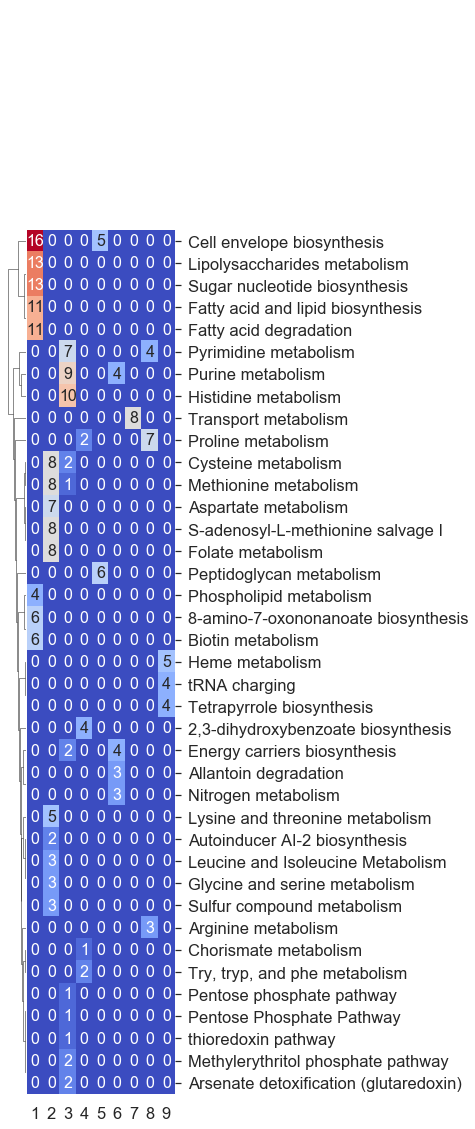

In [55]:
pathway_genes = pathway_genes.rename({'Tyrosine, Tryptophan, and Phenylalanine Metabolism' : 'Try, tryp, and phe metabolism'})
pathway_genes = pathway_genes.rename({'Colanic acid building blocks biosynthesis' : 'Colanic acid biosynthesis'})

plt.figure(figsize = (20,20))
plt.style.use('seaborn')

# create heatmaps of overlap between genes in each groups
sns.set(font_scale=1.4)
labels = ['1', '2', '3', '4', '5', '6', '7', '8', '9']
sns.set(font_scale=1.5)
g = sns.clustermap(pathway_genes, row_cluster=True, col_cluster = False, xticklabels = labels, annot = True, cmap = 'coolwarm',  annot_kws={"size": 16}, figsize = (3, 20))
#plt.ylabel('Significant pathway', fontsize = 32)
#plt.xlabel('Cluster', fontsize = 32)
#plt.xticks(fontsize = 24)
#plt.yticks(fontsize = 24)
g.cax.set_visible(False)
#plt.savefig("Figure4B_2_greedy_bothdir.eps", format = 'eps', bbox_inches="tight") 
#plt.savefig("Figure4B_2_greedy_bothdir.svg", format = 'svg', bbox_inches="tight") 
plt.show()

### Heatmap - (Supplementary figure 6c - number of genes associated to each signficant pathway for each antibiotic class)

In [56]:
### Get heatmap showing the number of antibiotics associated with each significant pathway

### Get a list of all the significant pathways (grouped)

### need a matrix of number of genes per cluster per sig. pathway - sum the grouped pathways
pathway_ab = pd.DataFrame(index = sig_pathways2)

count = 0
for a in df_AB_all.columns:
    col = [] # col for number of genes in each pathway

    for i in sig_pathways2:
        
        
        
        genes_path = []
        for ind, data in sig_pathways_clusters.items():
            for path, genes in data.items():
                if path == i:
                    for ge in genes:
                        if df_AB_all[a][gene_name_dic[ge]] > 0.0:
                            genes_path.append(ge)
        for ind, data in sig_pathways_clusters40.items():
            for path, genes in data.items():
                if path == i:
                    for ge in genes:
                        if df_AB_all[a][gene_name_dic[ge]] > 0.0:
                            genes_path.append(ge)
                    
                    
                                    
        if i in grouped_sig_pathways.keys():
            for pathway in grouped_sig_pathways[i]:
                for ind, data in sig_pathways_clusters.items():
                    for path, genes in data.items():
                        if pathway == path:
                            for ge in genes:
                                if df_AB_all[a][gene_name_dic[ge]] > 0.0:
                                    genes_path.append(ge)
                                    
                for ind, data in sig_pathways_clusters40.items():
                    for path, genes in data.items():
                        if pathway == path:
                            for ge in genes:
                                if df_AB_all[a][gene_name_dic[ge]] > 0.0:
                                    genes_path.append(ge)
                

                                   
        genes_path = list(set(genes_path))
        #print(a, genes_path) 
        col.append(len(genes_path))
    pathway_ab.insert(count, column = a, value = col)
    count += 1
    

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

<Figure size 576x396 with 0 Axes>

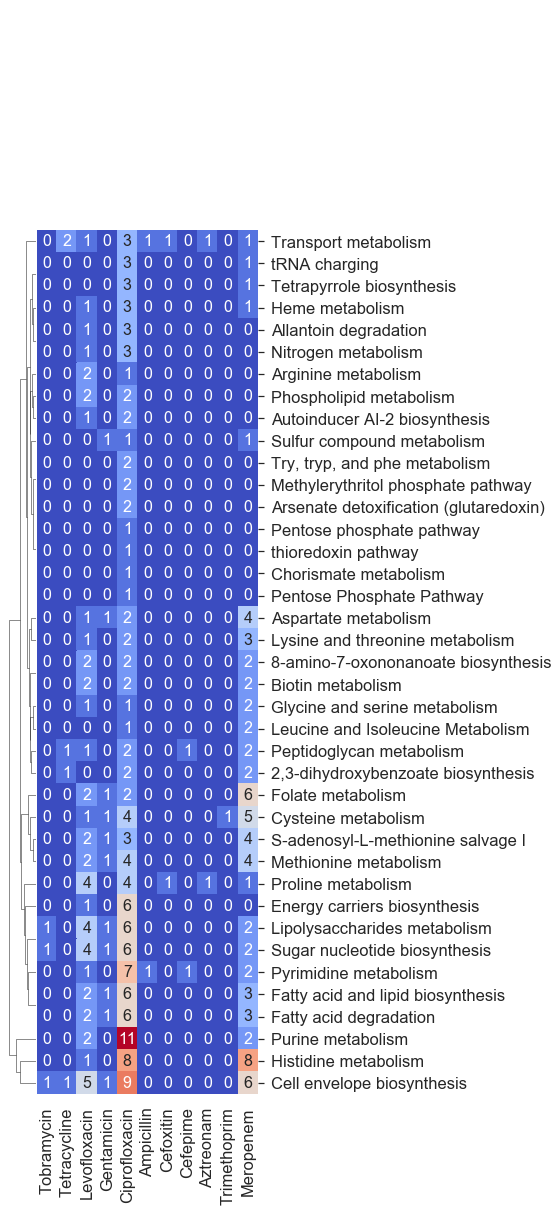

In [57]:
pathway_ab = pathway_ab.rename({'Tyrosine, Tryptophan, and Phenylalanine Metabolism' : 'Try, tryp, and phe metabolism'})
pathway_ab = pathway_ab.rename({'Colanic acid building blocks biosynthesis' : 'Colanic acid biosynthesis'})

plt.figure()
plt.style.use('seaborn')

# create heatmaps of overlap between genes in each groups
sns.set(font_scale=1.5)

g = sns.clustergrid = sns.clustermap(pathway_ab, row_cluster = True, col_cluster = False, annot = True, cmap = 'coolwarm', annot_kws={"size": 16},figsize = (4.5, 20))
#plt.ylabel('Antibiotic', fontsize = 32)
#plt.xlabel('Antibiotic', fontsize = 32)
g.cax.set_visible(False)
plt.yticks(fontsize = 16)
#plt.savefig("Figure5C_FVAgreedy_bothdir.eps", format = 'eps', bbox_inches="tight") 
#plt.savefig("Figure5C_FVAgreedy_bothdir.svg", format = 'svg', bbox_inches="tight") 
plt.show()

###  Figure 6b

In [93]:
# group together some subsystems 
systems = {}
systems['Cell Wall'] =  ['Murein Biosynthesis',
                         'Cell Envelope Biosynthesis', 
                         'Lipopolysaccharide Biosynthesis / Recycling',
                         'Glycerophospholipid Metabolism', 
                         'Murein Recycling',
                            'Membrane Lipid Metabolism']
                        
systems['Nucleotides Metabolism'] = ['Nucleotide Salvage Pathway',
                                     'Folate Metabolism',
                                     'Purine and Pyrimidine Biosynthesis']
                        
systems['Amino Acid Metabolism'] = ['Arginine and Proline Metabolism',
                                    'Valine, Leucine, and Isoleucine Metabolism',
                                    'Tyrosine, Tryptophan, and Phenylalanine Metabolism',
                                    'Alanine and Aspartate Metabolism',
                                    'Histidine Metabolism',
                                    'Cysteine Metabolism',
                                    'Glycine and Serine Metabolism', 
                                    'Threonine and Lysine Metabolism', 
                                   'Glutamate Metabolism', 
                                   'Methionine Metabolism']

systems['Carbohydrate Metabolism'] = ['Anaplerotic Reactions', 
                                     'Citric Acid Cycle',
                                     'Glycolysis/Gluconeogenesis',
                                     'Pyruvate Metabolism',
                                     'Pentose Phosphate Pathway',
                                     'Glyoxylate Metabolism', 
                                     'Methylglyoxal Metabolism']

systems['Transport'] = ['Transport, Outer Membrane Porin', 
                        'Transport, Outer Membrane',
                        'Transport, Inner Membrane']

systems['Alternative Carbon Metabolism'] = ['Alternate Carbon Metabolism']
systems['Cofactor and Prosthetic Group Metabolism'] = ['Cofactor and Prosthetic Group Biosynthesis']
systems['Energy metabolism'] = ['Oxidative Phosphorylation']
systems['Inorganic Transport and Metabolism'] = ['Inorganic Ion Transport and Metabolism']
systems['Nitrogen Metabolism'] = ['Nitrogen Metabolism']






#.iloc[:, ::-1].iloc[:, ::-1].iloc[:, ::-1]

### Number of reactions in each cluster belonging to each metabolic system

In [94]:

reacs = []
for r in m.reactions:
    reacs.append(r.id)
df_reacs_ss_all = pd.DataFrame(index = reacs)

count = 0
for s, subs in systems.items():
 
    s_genes = []
    for r in m.reactions:
        r_s = 0        
        if r.subsystem in subs:

            r_s = 1
        s_genes.append(r_s)
    
    df_reacs_ss_all.insert(count, column = s, value = s_genes)
    count += 1

In [95]:
clusters_include = [0, 1, 2, 3, 4, 5, 6, 7, 8]
df_reacs_c = pd.DataFrame(index = reacs)
for ind, i in enumerate(c):
    if ind in clusters_include:
        col = []
        count = 0
        for node in reacs:
            if node in c[ind]:
                col.append(1)
            else:
                col.append(0)
        df_reacs_c.insert(count, column = ind+1, value = col)
        count += 1
            
        
df_c_ss = df_reacs_c.T.dot(df_reacs_ss_all).T
df_c_ss = df_c_ss.iloc[:, ::-1]

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

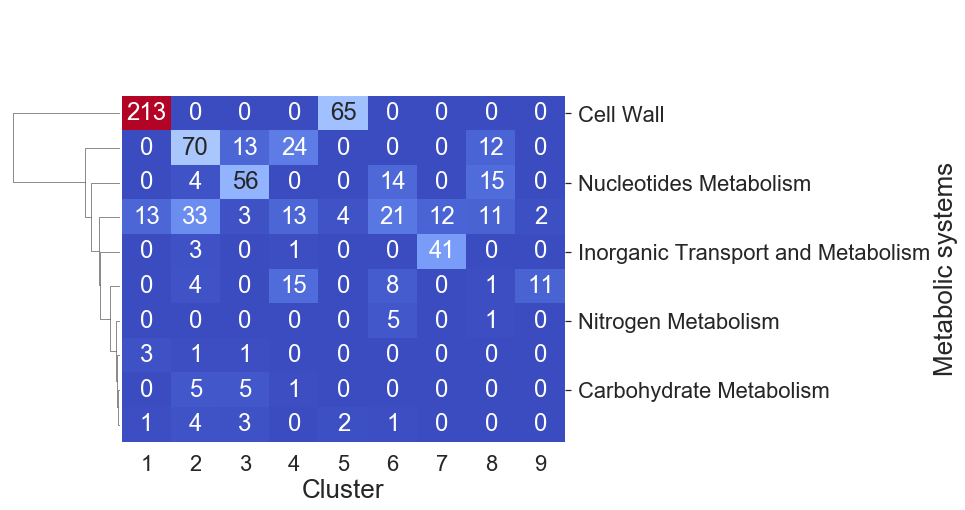

In [96]:
# get the number of reactions associated to each cluster for each metabolic system



g = sns.clustermap(df_c_ss, annot = True, method = 'average', cmap = 'coolwarm', row_cluster=True, col_cluster=False, square=False, fmt='g', figsize = (10,8), annot_kws={"size": 24})
sns.set(font_scale=1.8)
sns.set(font='arial')
plt.xticks(fontsize = 22)
g.ax_heatmap.set_xlabel('Cluster', fontsize = 26)
g.ax_heatmap.set_ylabel('Metabolic systems', fontsize = 26)


g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xmajorticklabels(), fontsize = 22)
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_ymajorticklabels(), fontsize = 22)
g.cax.set_visible(False)

#plt.savefig('SuppFigureB_FVAgreedy_bothdir.eps', format = 'eps', bbox_inches="tight")
#plt.savefig('SuppFigureB_FVAgreedy_bothdir.svg', format = 'svg', bbox_inches="tight")

### Figure 6c

In [97]:
# Part c)

# Create dataframe showing the number of genes from each antibiotic in each cluster
df_AB_all_bin = df_AB_all.copy()
df_AB_all_bin[df_AB_all_bin> 0] = 1

df_c_gene = pd.DataFrame(index = genes_ALL)
for ind, i in enumerate(c):
    if ind in clusters_include:
        col = []
        count = 0
        for node in genes_ALL:
            if gene_name_dic2[node] in c[ind]:
                col.append(1)
            else:
                col.append(0)
        df_c_gene.insert(count, column = ind+1, value = col)
        count += 1
    
df1, df2 = df_AB_all_bin.align(df_c_gene, join='outer', axis=0)  
df_c_ab = df1.T.dot(df2)
df_c_ab = df_c_ab.iloc[:, ::-1]

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

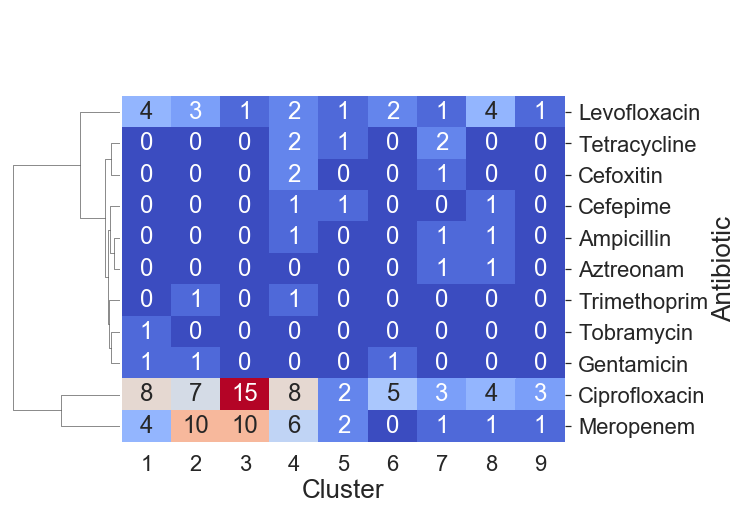

In [98]:
g = sns.clustermap(df_c_ab, annot = True, method = 'average', cmap = 'coolwarm', row_cluster=True, col_cluster=False, square=False, figsize = (10,8), annot_kws={"size": 24})
sns.set(font_scale=1.8)
sns.set(font='arial')
#plt.xticks(fontsize = 22)
g.ax_heatmap.set_xlabel('Cluster', fontsize = 26)
g.ax_heatmap.set_ylabel('Antibiotic', fontsize = 26)


g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xmajorticklabels(), fontsize = 22)
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_ymajorticklabels(), fontsize = 22)
g.cax.set_visible(False)

#plt.savefig('SuppFigureC_FVAgreedy_bothdir.eps', format = 'eps', bbox_inches="tight")
#plt.savefig('SuppFigureC_FVAgreedy_bothdir.svg', format = 'svg', bbox_inches="tight")

### Supplementary figure 7 showing the subsystems vs. genes, ordered via the clustering using the bilouvain approach

In [99]:
# Get DataFrame of all genes and metabolites in the network 
df_reacs_genes_all = pd.DataFrame(index = reacs)

count = 0
for ind, i in enumerate(nodes1):
    col = []
    for j in reacs:
        if (i, j) in edges:
            col.append(1)
        else:
            col.append(0)
    df_reacs_genes_all.insert(count, column = i, value = col)
    count += 1
    


In [100]:
df_genes_sss_all = df_reacs_genes_all.T.dot(df_reacs_sss_all)

In [101]:
subsystems = []
for s, sub in systems.items():
    #print(sub)
    subsystems = subsystems + sub
subsystems = list(set(subsystems))  
cluster_IDS = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
df_reacs_sss = pd.DataFrame(index = nodes2)

count = 0
for s in subsystems:
    #if s == 'Glycerophospholipid Metabolism':
 
    s_genes = []
    for r in nodes2:
        r_s = 0        
        if m.reactions.get_by_id(r).subsystem in s:
            #print(m.reactions.get_by_id(r).subsystem)
            r_s = 1
        s_genes.append(r_s)

    df_reacs_sss.insert(count, column = s, value = s_genes)
    count += 1
    
clusters_dfs = {}

for ind, i in enumerate(c):
    reacs = []
    for r in i:
        if r in nodes2:
            reacs.append(r)
    if ind in cluster_IDS:
        df_reacs_sss_c = df_reacs_sss.T[reacs]
    
    clusters_dfs[ind] = df_reacs_sss_c.T

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

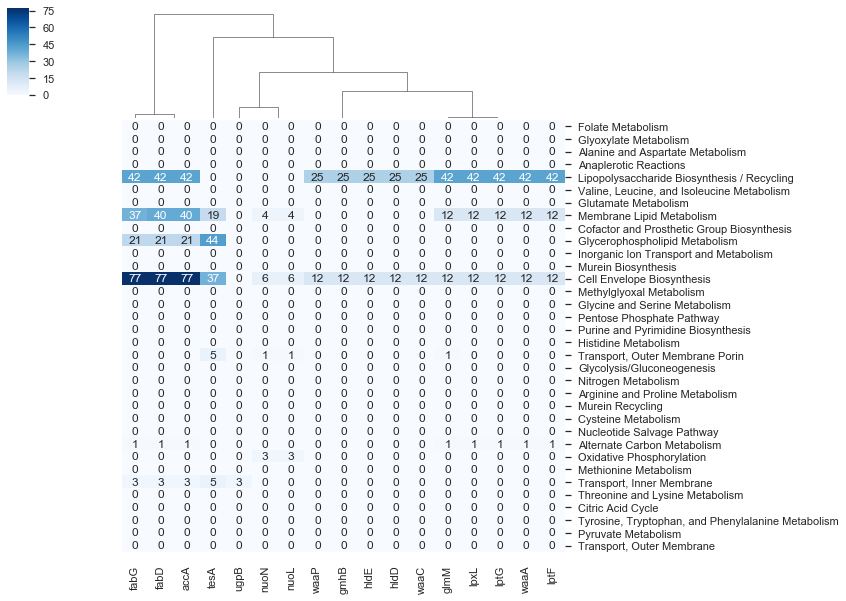

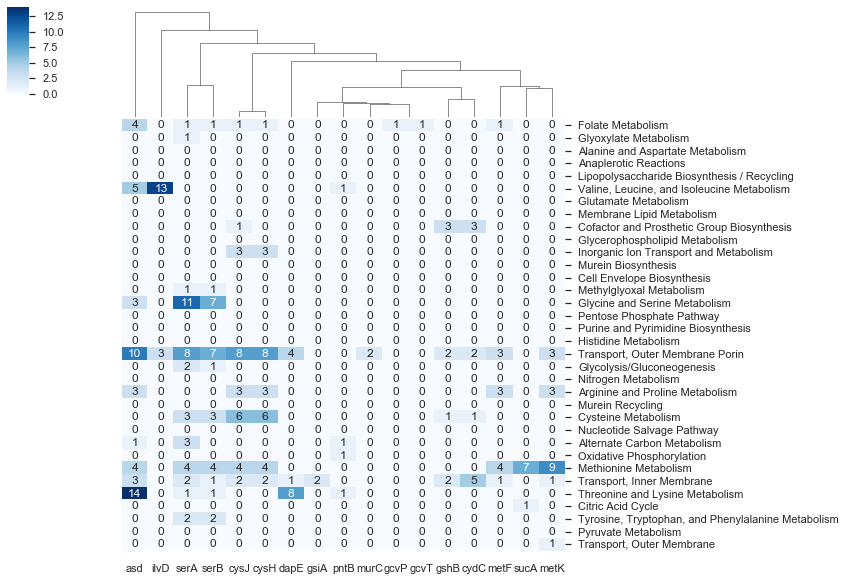

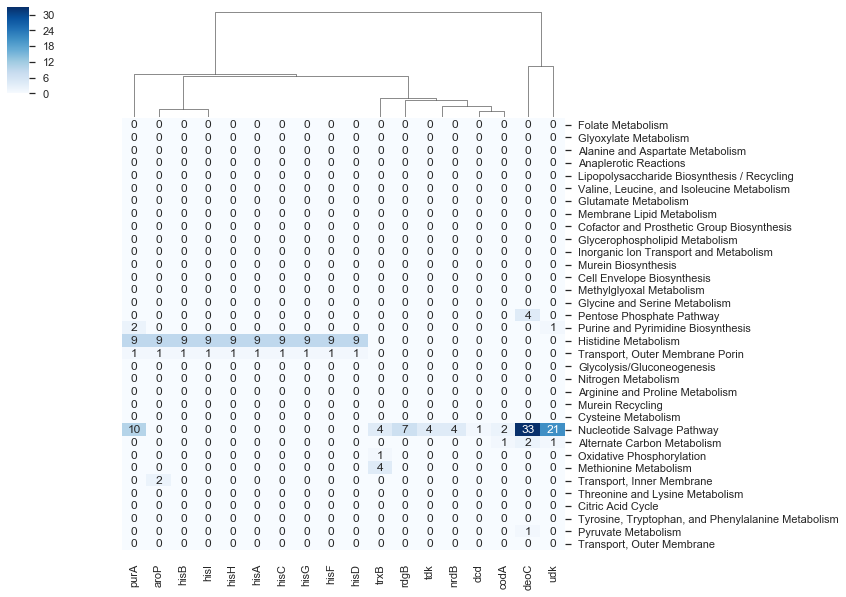

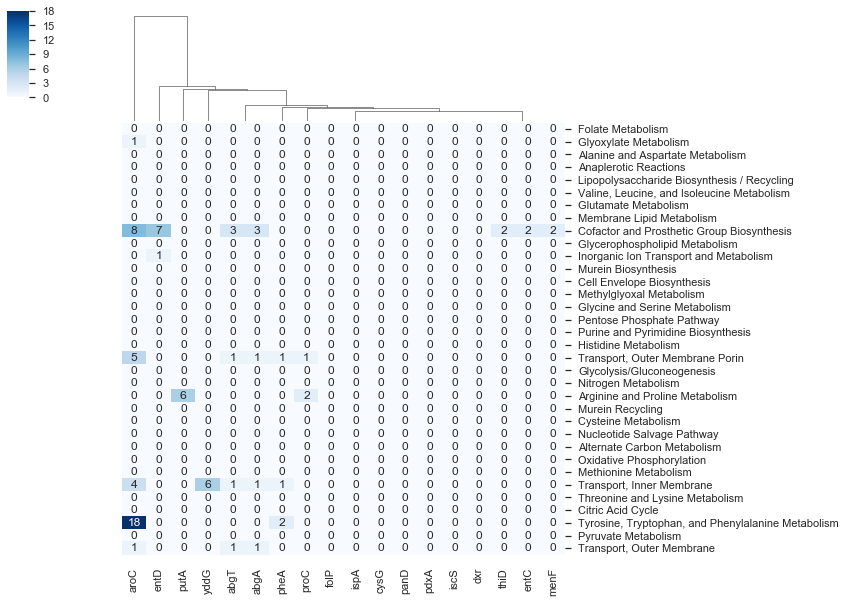

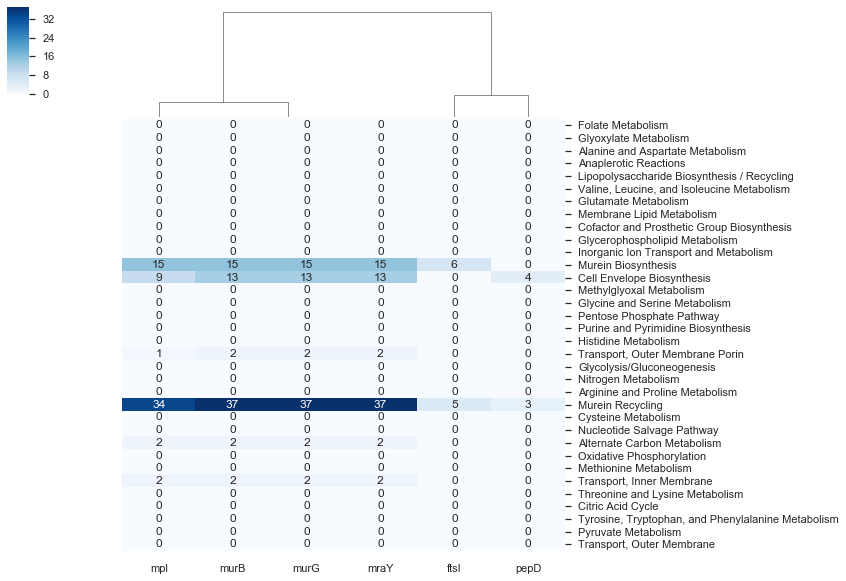

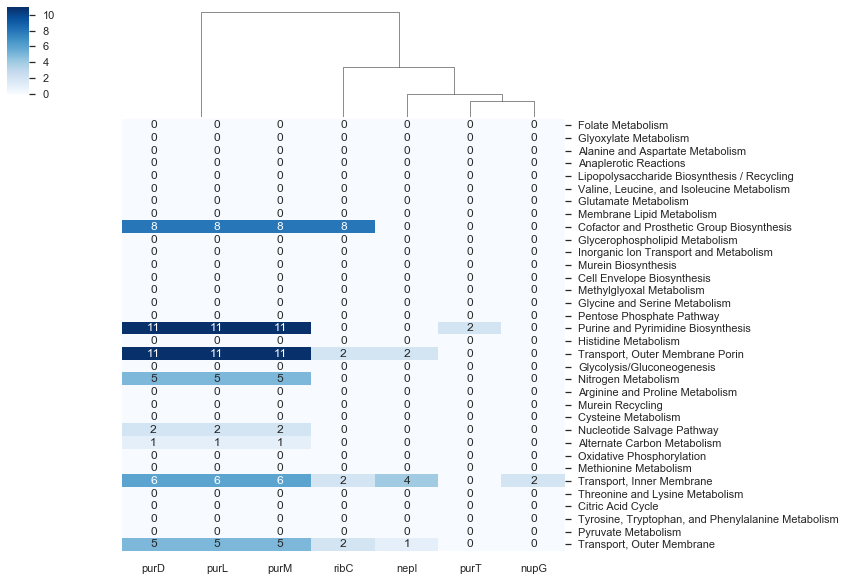

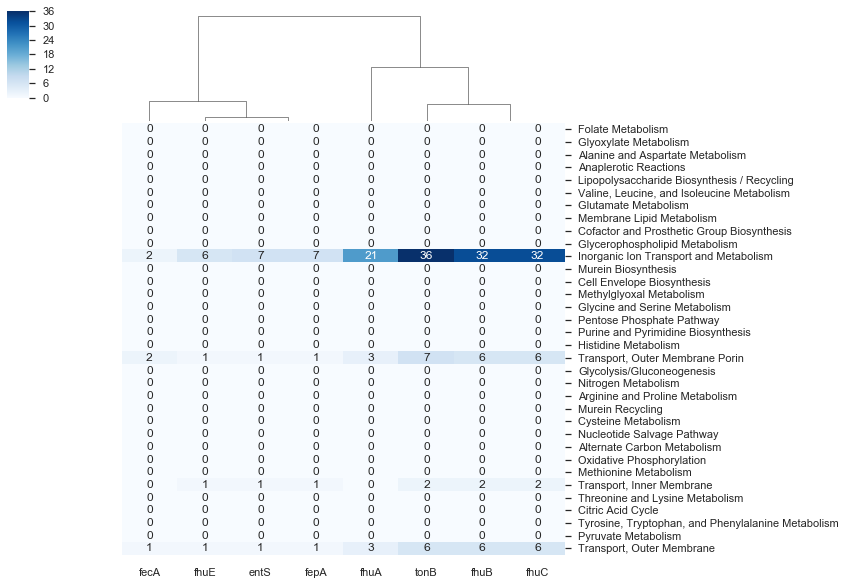

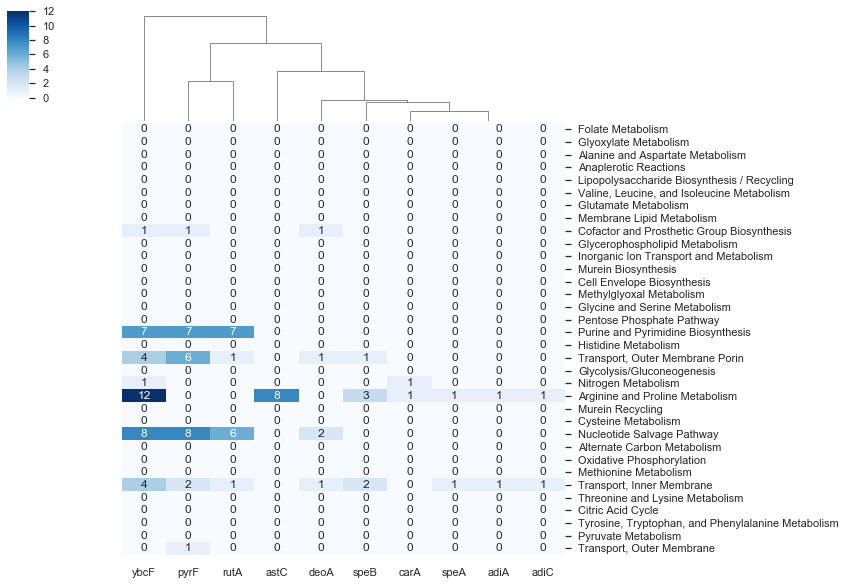

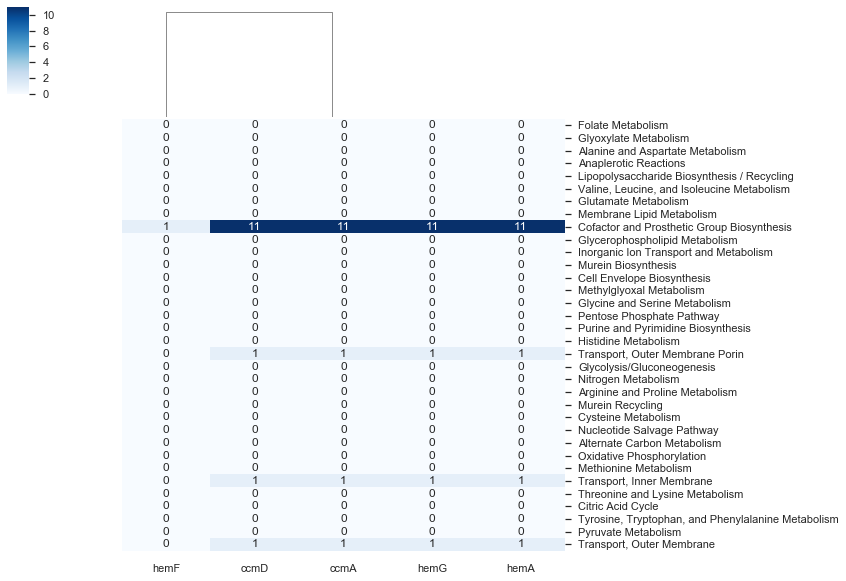

In [102]:
# The heatmap of all genes but ordered by the clusters they are in and similar to

df_genes_sss_c = {}
gene_order = {}

# make a dataframe containing edges 
cluster_IDS = [0, 1, 2, 3, 4, 5, 6, 7, 8]
for clusterID in cluster_IDS:

    nodes_c = []
    for i in c[clusterID]:
        if i in m.reactions:
            nodes_c.append(i)
    nodes_c = list(set(nodes_c))

    df_reacs_genes_c = pd.DataFrame(index = nodes_c) # get the reaction vs subsystems dataframe for each cluster (i.e. 1 if the reaction is involved in the subsystem)

    count = 0
    for ind, i in enumerate(nodes1):
        #if i == 'nuoN':
        col = []
        if i in c[clusterID]:
            for indj, j in enumerate(nodes_c):
                if (i, j) in edges:
                    #print(i, j, m.reactions.get_by_id(j).subsystem)
                    col.append(1)
                else:
                    col.append(0)
            df_reacs_genes_c.insert(count, column = i, value = col) # create a dataframe for the individual cluster showing the relationship between genes and reactions (i.e. if a gene reduces flux span)
            count += 1
    



    df_genes_sss = df_reacs_genes_c.T.dot(clusters_dfs[clusterID])
    df_genes_sss_c[clusterID] = df_genes_sss # get the dataframe showing the number of reactions effected in each subsystem by the gene


    g = sns.clustermap(df_genes_sss.T, annot = True, cmap='Blues', row_cluster=False
    , col_cluster=True)


    gene_order[clusterID] = g.dendrogram_col.dendrogram['leaves']

In [103]:
# Get DataFrame of genes vs subsystems reordered by the genes in each cluster (and according to how similar the genes are to each other in terms of phenotype)

gene_order_full = []
gene_order_full = list(df_genes_sss_c[0].T.columns[gene_order[0]])
for i, j in gene_order.items():
    if i > 0:
        gene_order_full = gene_order_full + list(df_genes_sss_c[i].T.columns[j])
        
df_genes_sss = df_reacs_genes_all.T.dot(df_reacs_sss_all)
df_genes_sss_reorder = df_genes_sss.T.reindex(columns=gene_order_full)

[Text(0.5, 0, 'fabG'),
 Text(1.5, 0, 'fabD'),
 Text(2.5, 0, 'accA'),
 Text(3.5, 0, 'tesA'),
 Text(4.5, 0, 'ugpB'),
 Text(5.5, 0, 'nuoN'),
 Text(6.5, 0, 'nuoL'),
 Text(7.5, 0, 'waaP'),
 Text(8.5, 0, 'gmhB'),
 Text(9.5, 0, 'hldE'),
 Text(10.5, 0, 'hldD'),
 Text(11.5, 0, 'waaC'),
 Text(12.5, 0, 'glmM'),
 Text(13.5, 0, 'lpxL'),
 Text(14.5, 0, 'lptG'),
 Text(15.5, 0, 'waaA'),
 Text(16.5, 0, 'lptF'),
 Text(17.5, 0, 'asd'),
 Text(18.5, 0, 'ilvD'),
 Text(19.5, 0, 'serA'),
 Text(20.5, 0, 'serB'),
 Text(21.5, 0, 'cysJ'),
 Text(22.5, 0, 'cysH'),
 Text(23.5, 0, 'dapE'),
 Text(24.5, 0, 'gsiA'),
 Text(25.5, 0, 'pntB'),
 Text(26.5, 0, 'murC'),
 Text(27.5, 0, 'gcvP'),
 Text(28.5, 0, 'gcvT'),
 Text(29.5, 0, 'gshB'),
 Text(30.5, 0, 'cydC'),
 Text(31.5, 0, 'metF'),
 Text(32.5, 0, 'sucA'),
 Text(33.5, 0, 'metK'),
 Text(34.5, 0, 'purA'),
 Text(35.5, 0, 'aroP'),
 Text(36.5, 0, 'hisB'),
 Text(37.5, 0, 'hisI'),
 Text(38.5, 0, 'hisH'),
 Text(39.5, 0, 'hisA'),
 Text(40.5, 0, 'hisC'),
 Text(41.5, 0, 'hisG'),
 Te

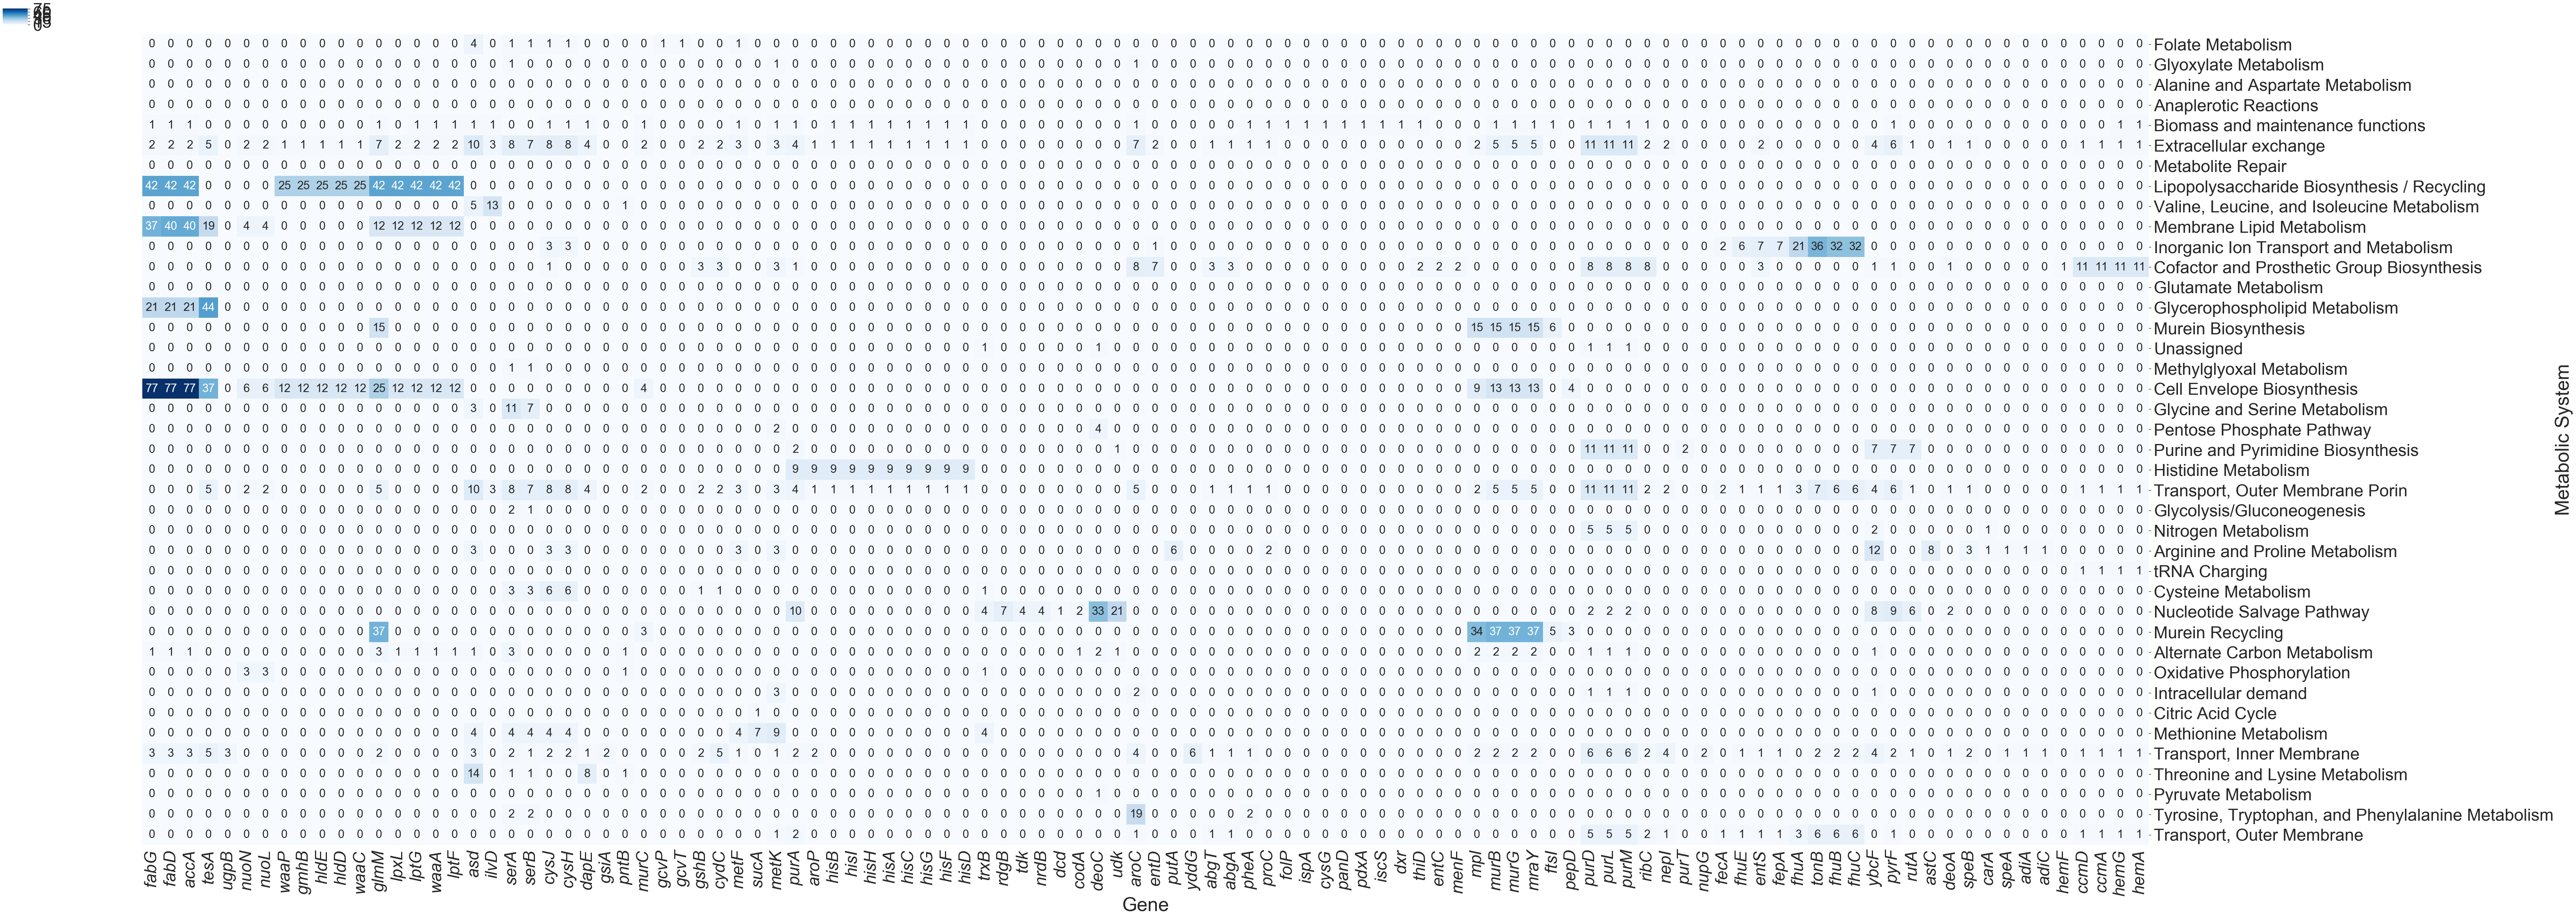

In [105]:
sns.set(font_scale=4.0)

g = sns.clustermap(df_genes_sss_reorder, annot = True, cmap='Blues', row_cluster=False
, col_cluster=False, figsize = (100, 40), annot_kws={"size": 30}, fmt = 'd')

g.ax_heatmap.set_xlabel('Gene', fontsize = 50)
g.ax_heatmap.set_ylabel('Metabolic System', fontsize = 50)
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_ymajorticklabels())
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xmajorticklabels(), rotation = 90, fontstyle = ("italic"))

#plt.savefig('SuppFig7_bothdir.eps', format = 'eps', bbox_inches="tight")
#plt.savefig('SuppFig7_bothdir.svg', format = 'svg', bbox_inches="tight")